# Biomarker detection for in vitro model of influenza


### By: Miguel A. Alcantar and Diogo M. Camacho
##### Last updated: 06/17/2019

1. Import preprocessed data for entire preprocessed gene set
    - Data were preprocessed in R by filtering with the following criteria
        - remove gene that have 0 counts in all samples
        - remove genes with multiple entrez mappings
        - remove genes with <5 counts in 75% of all the samples
    - The initial analysis was conducted on the entire preprocessed gene set using all samples
2. Run dimensionality reduction of the presence-absence data frame
    - Before any further analyses, the data were all z-score normalized (w.r.t gene) using scipy.stats
    - PCA
        - PCA was applied to the entire normalized count data matrix
        - TSNE was not used because the samples already clustered quite well with vanilla PCA
    - Note: Since we only have 8 samples 20 samples and ~14,000 genes, using ML on this entire data set is intractable. Additionally, we are searching for clinically viable biomarkers. We therefore decided to continue analyses using a subset of genes that are likely secreted and carry signal peptides (which facilitates secretion). This reduced our feature space to 33 genes. 
3.  Import preprocessed data for genes with secreted products and signal peptides (SS)
    - This will be done using four drugs: isoniazid, rifampicin, streptomycin, and ethambutol
        - These drugs will be used because they have the largest union of strains 
    - z-score normalization is applied to subset of data comprised of control_18 and viral_18 groups. This is because we don't use the other groups in subsequent analyses.
    - We then run PCA on these groups and see robust segregation of the control and virally-infected group.
    - A heatmap / clustermap futher confirms that the majority of differentially expressed genes (with secreted products) are upregulated in the virally-infected group; only a gene was downregulated. The stark differentiation with unsupervised techniques indicates that ML models may only require a small amount of information to correctly classify these groups.
    
    - RBF SVM
        - Run hyperparameter sweep using cross-validation and test
        - Do this removing the same genes Erol did
        - Do this for PCA-values
        - Do this without removing genes
4. Machine Learning
    - Implement stacked supervised ML models to facilitate biomarker identification
    - Models include:
        - Linear SVM
            - Run hyperparameter sweep using cross-validation -- we save best model to disk
            - Run model on test set
        - Random Forest model
            - Run hyperparameter sweep using random sampling -- we save best model to disk
            - Run model on test set and conduct feature selection using gini importance
5. To do:
    - get more data
    


In [1]:
# importing general packages
import random
import collections
import numpy as np
import pprint as pp
import pandas as pd
from pylab import *
import seaborn as sns
from tqdm import tqdm
from matplotlib import pyplot as plt
from IPython.display import clear_output
import statsmodels.stats.multitest as multi

# importing scipy packages
import scipy as sp

# importaing sklearn packages
from sklearn import linear_model
from sklearn import decomposition
from sklearn.pipeline import Pipeline
# from sklearn.utils.fixes import signature
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn import svm
from sklearn.metrics import roc_curve, auc
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import average_precision_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

# package for permutation importance -- compatable with sklearn models
import eli5
from eli5.sklearn import PermutationImportance

# package for saving ML models to disk
import pickle

# importing packages for biological analysis
# import mygene
# from biothings_client import get_client

import os
import sys
import warnings
from utils import * # import external functions that will be useful throughout analysis
from config_RNAseq_data import *
from unsupervised_analysis import *
# from supervised_ML_training import *
# from supervised_ML_testing import *

# ignore warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    warnings.filterwarnings("ignore", category=UserWarning)

sns.set_style('white')
pd.options.display.float_format = '{:,.7f}'.format
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1500)

ImportError: No module named seaborn

# Data analysis

In [2]:
# data analysis: all samples + all genes 
# loading in preprocessed count data, gene IDs, and metadata
count_data_chip_df, gene_ids_chip, sample_metadata_chip_df = load_chip_data()

# z-score normalization
count_data_chip_zScore_df = standardize_data(count_data_chip_df)

# running PCA
count_data_chip_PCA_df, count_data_chip_PCA_obj = run_PCA(count_data_chip_zScore_df)

# plotting PCA
plotPCA(count_data_chip_PCA_df, count_data_chip_PCA_obj, sample_metadata_chip_df,gene_ids_chip,
            [2,3], save_plot=True, output_loc='../../figs/machine_learning/PCA_chip_data_')

NameError: name 'load_chip_data' is not defined

In [3]:
sample_metadata_chip_df
sample_to_group = dict(zip(sample_metadata_chip_df.sample_name, 
                                   sample_metadata_chip_df.group_time))
samples_control18_virus_18 = [key for key, value in sample_to_group.items() if 'control_18' in value.lower() or 'virus_18' in value.lower()]

NameError: name 'sample_metadata_chip_df' is not defined

In [4]:
count_data_chip_df.loc[samples_control18_virus_18].sort_index().T.to_csv('../data/gene_lists/count_data_all_YETI.tsv',sep='\t')

NameError: name 'count_data_chip_df' is not defined

In [5]:
# data analysis with only differentialy expressed and secreted genes
count_data_chip_secreted_signal_df, count_data_chip_ss_cont_vir_18_df, secreted_biomarkers = grab_signal_secreted_genes(count_data_chip_df, sample_metadata_chip_df, time=18)

# z-score normalization
count_data_chip_ss_zScore_df = standardize_data(count_data_chip_ss_cont_vir_18_df)

# running PCA
count_data_chip_ss_PCA_df, count_data_chip_ss_PCA_obj = run_PCA(count_data_chip_ss_zScore_df)

# plotting PCA
plotPCA(count_data_chip_ss_PCA_df, count_data_chip_ss_PCA_obj, sample_metadata_chip_df, gene_ids_chip,
            [1,2], save_plot=True, output_loc='../../figs/machine_learning/PCA_chip_data_')


sns.clustermap(count_data_chip_ss_zScore_df, metric = 'euclidean',  method = 'complete', center=0)
plt.savefig('../../figs/machine_learning/cluster_heatmap_18hrs.pdf', dpi=400)
plt.savefig('../../figs/machine_learning/cluster_heatmap_18hrs.svg', dpi=400)
plt.savefig('../../figs/machine_learning/cluster_heatmap_18hrs.png', dpi=400)




NameError: name 'grab_signal_secreted_genes' is not defined

In [6]:
plot_loadings(count_data_chip_ss_PCA_obj, secreted_biomarkers, [1,2])

NameError: name 'plot_loadings' is not defined

## Support Vector Machine

In [8]:
# run SVM
from sklearn.linear_model import SGDClassifier
from supervised_ML_training import *

train_linear_SVM(count_data_chip_ss_zScore_df,sample_metadata_chip_df, '../data/models/SVM_linear_chip_SS_model', 
                  '../data/models_analysis/SVM_linear_chip_SS_training', save = True)

runLinearSVM(count_data_chip_ss_zScore_df, sample_metadata_chip_df, 10, 0.8,
             '../data/models/SVM_linear_chip_SS_model',
             '../data/models_analysis/SVM_linear_chip_SS',save=True)

The best parameters are {'clf__alpha': 0.01, 'fs__threshold': 0.0} with a score of 1.00


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.80it/s]


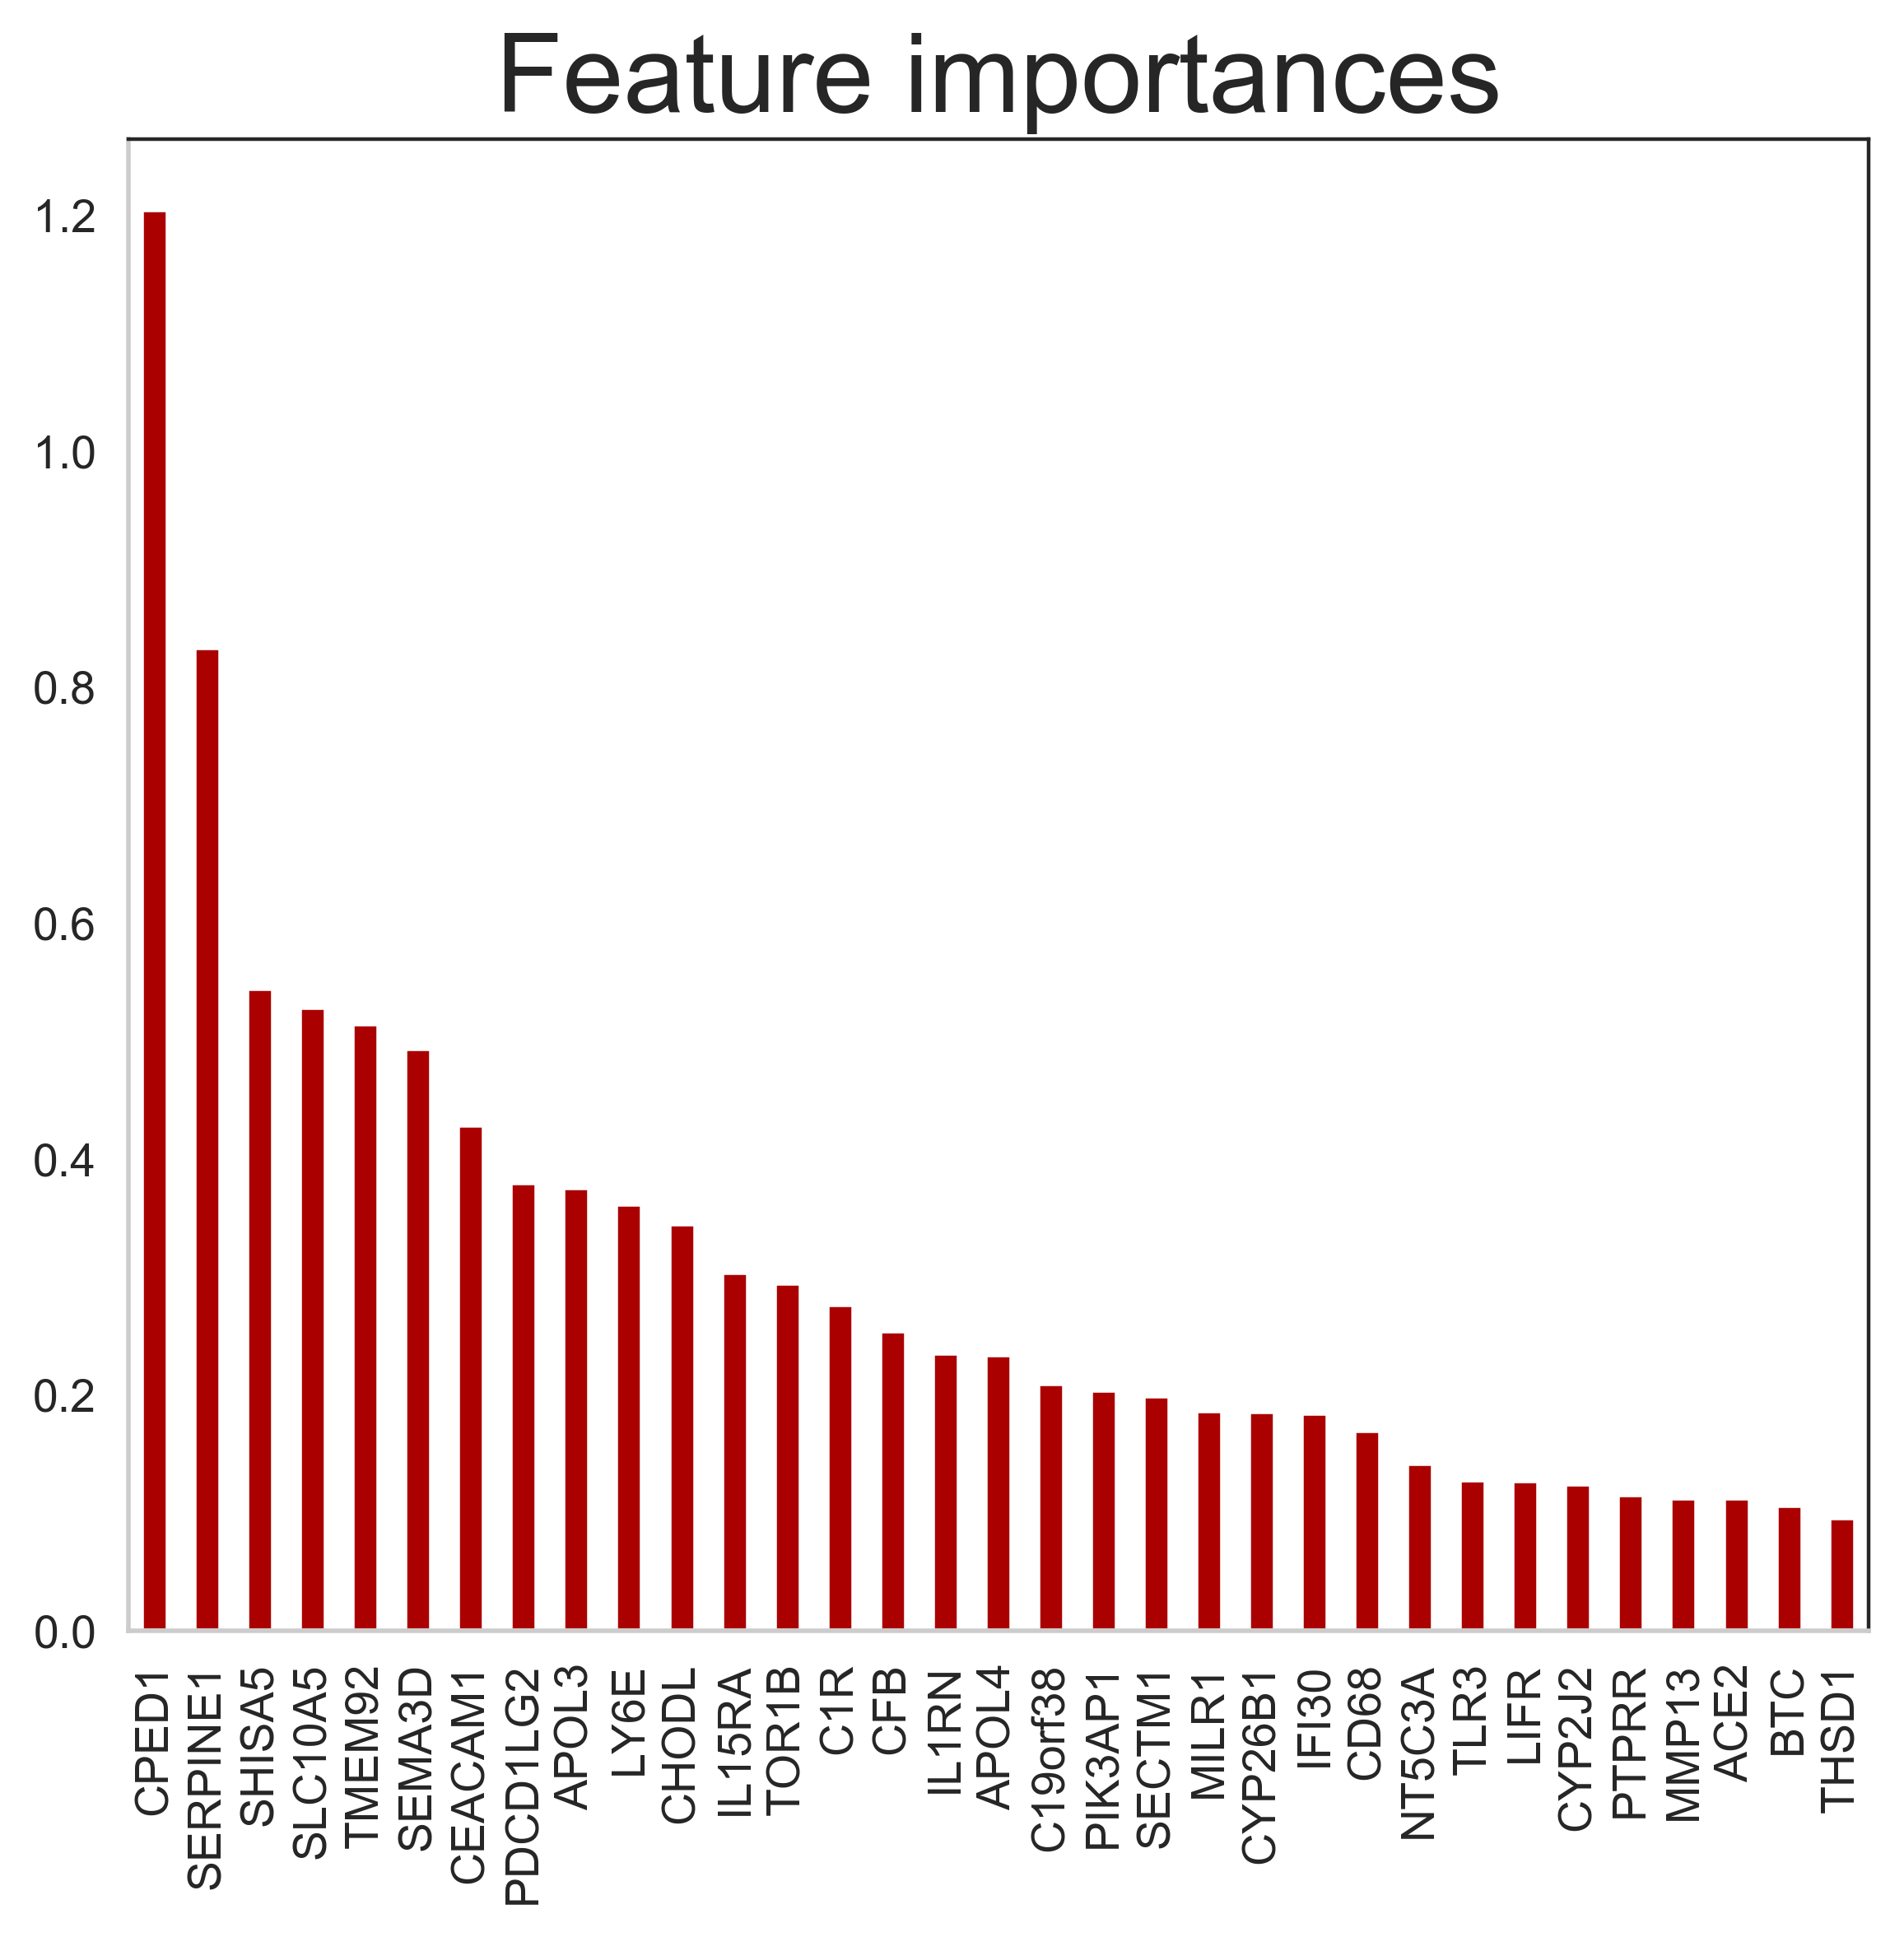

In [6]:
# weights results

weights_summary_chip_ss_df = pd.read_csv('../data/models_analysis/SVM_linear_chip_SS_all_weights.csv', index_col= 0)
plot_weights(weights_summary_chip_ss_df)


## Random Forest

In [7]:
train_random_forest_estimator(count_data_chip_ss_zScore_df, sample_metadata_chip_df, 
                                 '../data/models/RF_chip_SS_model', '../data/models_analysis/RF_chip_SS_training',
                              save = True)

run_RF(count_data_chip_ss_zScore_df, sample_metadata_chip_df, 2,0.8,
                                 '../data/models/RF_chip_SS_model', '../data/models_analysis/RF_chip_SS_training',
                              save = True)

{'bootstrap': [True, False],
 'max_depth': [1, 3, 5, 7, 9, 11, 13, 15, 17, 20, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 3, 4, 5],
 'n_estimators': [10,
                  62,
                  114,
                  166,
                  218,
                  270,
                  322,
                  374,
                  426,
                  478,
                  531,
                  583,
                  635,
                  687,
                  739,
                  791,
                  843,
                  895,
                  947,
                  1000]}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.3min finished


The best predictor obtain an accuracy of: 1.0


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:33<00:00, 17.90s/it]
